In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#3. Main execution :
 #step A: Prepare Data
X, y = Load_Data("/kaggle/input/plantvillage-dataset/color")
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Step C: Level 2 Baseline (The Real Work)
pca = PCA(n_components=256, random_state=42)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)
My_Model = SVC(kernel="linear", C=1.0)
# Train
My_Model.fit(X_train, y_train)

# Predict
Predictions = My_Model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, Predictions)
print("SVM Accuracy:", accuracy)

Loading images: 100%|██████████| 54305/54305 [08:04<00:00, 112.08it/s]


SVM Accuracy: 0.7490102200534021


In [5]:
from sklearn.metrics import confusion_matrix

# true labels and predicted labels
y_true = y_test
y_pred = My_model.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
print(cm)

NameError: name 'My_model' is not defined

Detected 38 classes. Starting image loading...


Processing Classes: 100%|██████████| 38/38 [09:58<00:00, 15.75s/it]



Training set size: (43444, 3072)
Testing set size: (10861, 3072)

[Step B] Running Level 1 Baseline (Dummy)...
>> Dummy Accuracy (Guessing most frequent): 0.1015

[Step C] Training Level 2 Baseline (Random Forest)...
------------------------------
FINAL SHALLOW BASELINE ACCURACY: 0.6695
------------------------------


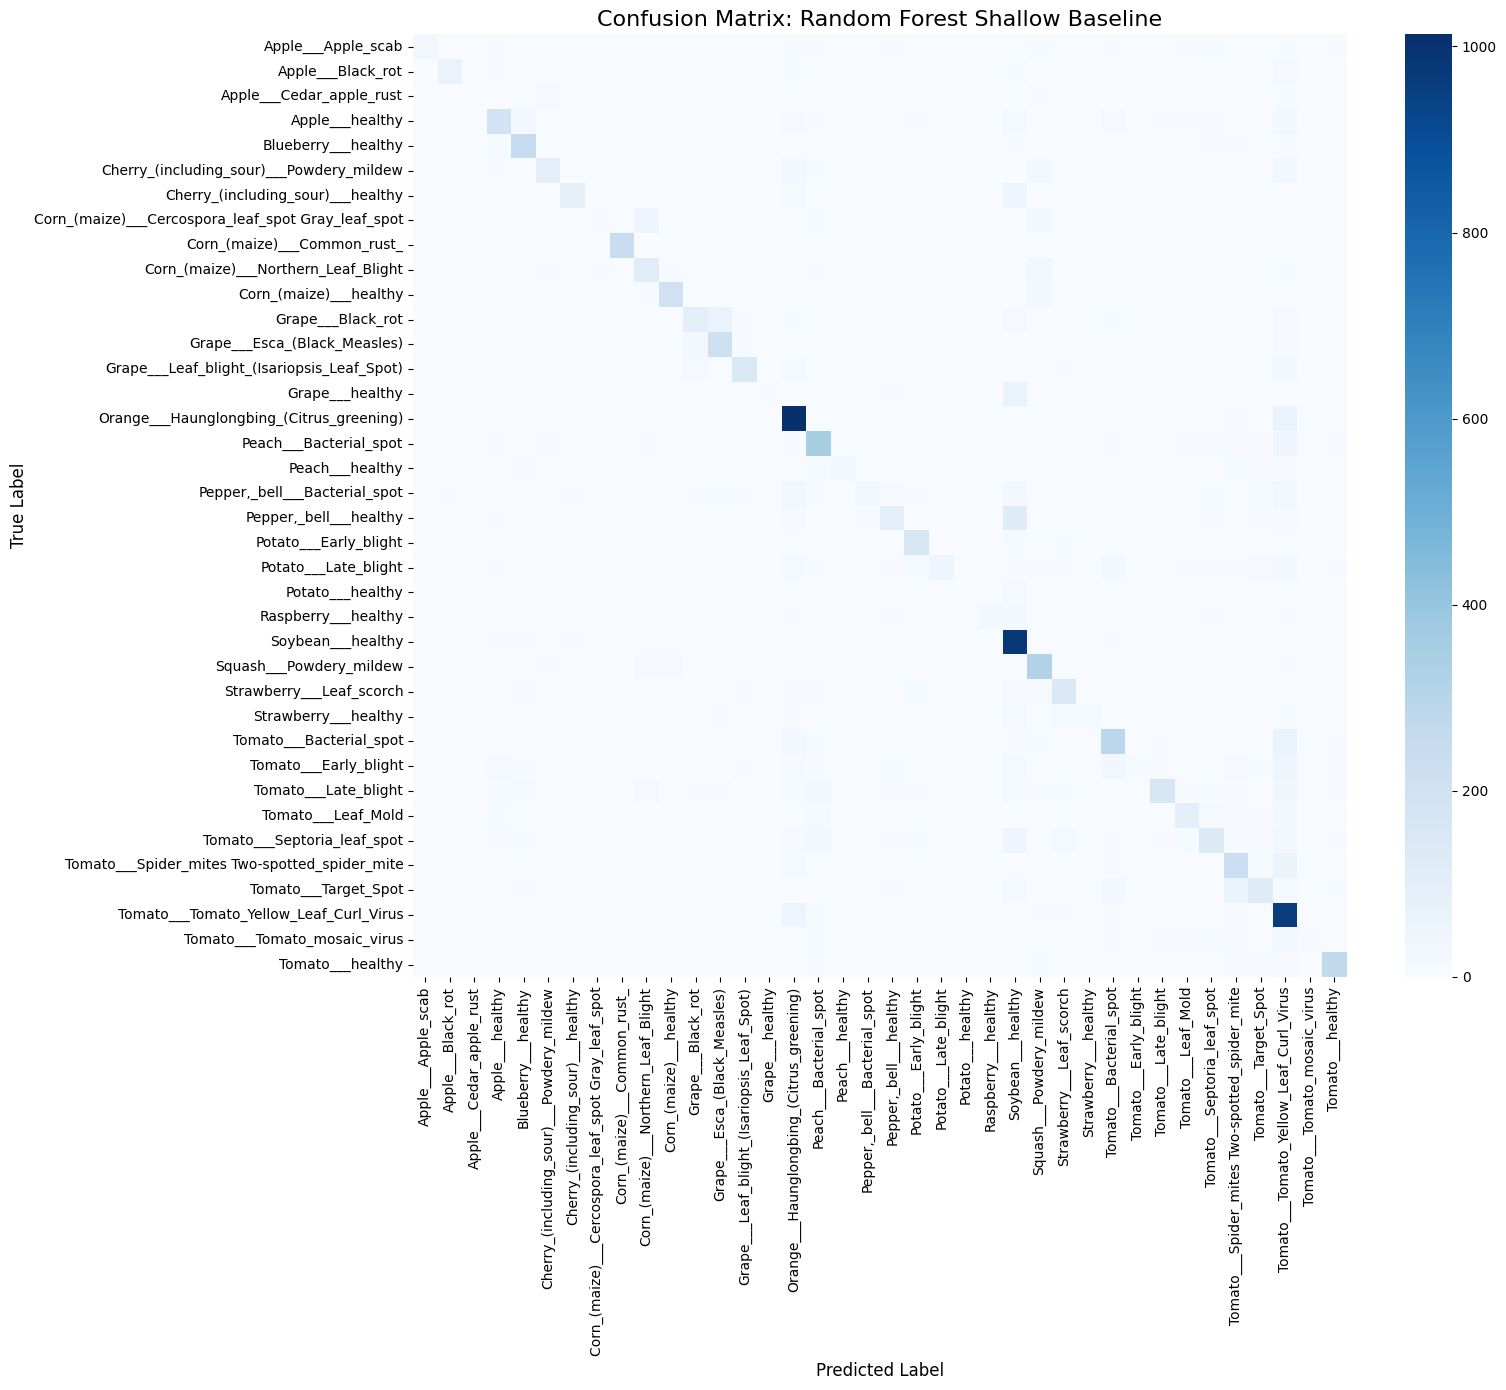


Detailed Classification Report (First 5 classes):


TypeError: got an unexpected keyword argument 'max_iter'

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==========================================
# 1. DEFINE Constants
# ==========================================
# Using 32x32 to keep the feature vector (32*32*3 = 3072) manageable for RAM
TARGET_SIZE = (32, 32) 
DATA_DIR = "/kaggle/input/plantvillage-dataset/color" # Path from your Week 1 EDA
SEED = 42

# ==========================================
# 2. FUNCTION Load_Data
# ==========================================
def load_data(directory):
    X = []
    y = []
    
    # Get sorted list of folders to ensure consistent label encoding
    class_folders = sorted([f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))])
    
    print(f"Detected {len(class_folders)} classes. Starting image loading...")
    
    for label in tqdm(class_folders, desc="Processing Classes"):
        path = os.path.join(directory, label)
        
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                # Read image
                img = cv2.imread(img_path)
                if img is None: continue
                
                # Pre-processing: Resize
                img_resized = cv2.resize(img, TARGET_SIZE)
                
                # CRITICAL STEP: Flatten 3D image (32, 32, 3) to 1D vector (3072,)
                vector = img_resized.flatten()
                
                X.append(vector)
                y.append(label)
            except Exception:
                continue # Skip corrupted images
                
    return np.array(X, dtype='uint8'), np.array(y)

# ==========================================
# 3. MAIN Execution
# ==========================================

# Step A: Prepare Data
X_raw, y_raw = load_data(DATA_DIR)

# Encode string labels (e.g., 'Tomato___Healthy') to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)

# Stratified Split (80% Train, 20% Test)
# 'stratify' ensures each class is represented equally in both sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.20, random_state=SEED, stratify=y_encoded
)

# Feature Scaling (Crucial for most ML algorithms)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw.astype(float))
X_test = scaler.transform(X_test_raw.astype(float))

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# --- Level 1: Dummy Baseline (The Floor) ---
print("\n[Step B] Running Level 1 Baseline (Dummy)...")
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_acc = dummy_model.score(X_test, y_test)
print(f">> Dummy Accuracy (Guessing most frequent): {dummy_acc:.4f}")

# --- Level 2: Shallow Baseline (The Standard) ---
print("\n[Step C] Training Level 2 Baseline (Random Forest)...")
# n_estimators=100 is a good balance. n_jobs=-1 uses all CPU cores.
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

# Step D: Evaluation
y_pred = rf_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"FINAL SHALLOW BASELINE ACCURACY: {final_acc:.4f}")
print("-" * 30)

# ==========================================
# 4. VISUALIZATION: Confusion Matrix
# ==========================================
def plot_results(y_true, y_pred, classes):
    # Create Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix: Random Forest Shallow Baseline', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Fixed: Removed 'max_iter'
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

plot_results(y_test, y_pred, le.classes_)

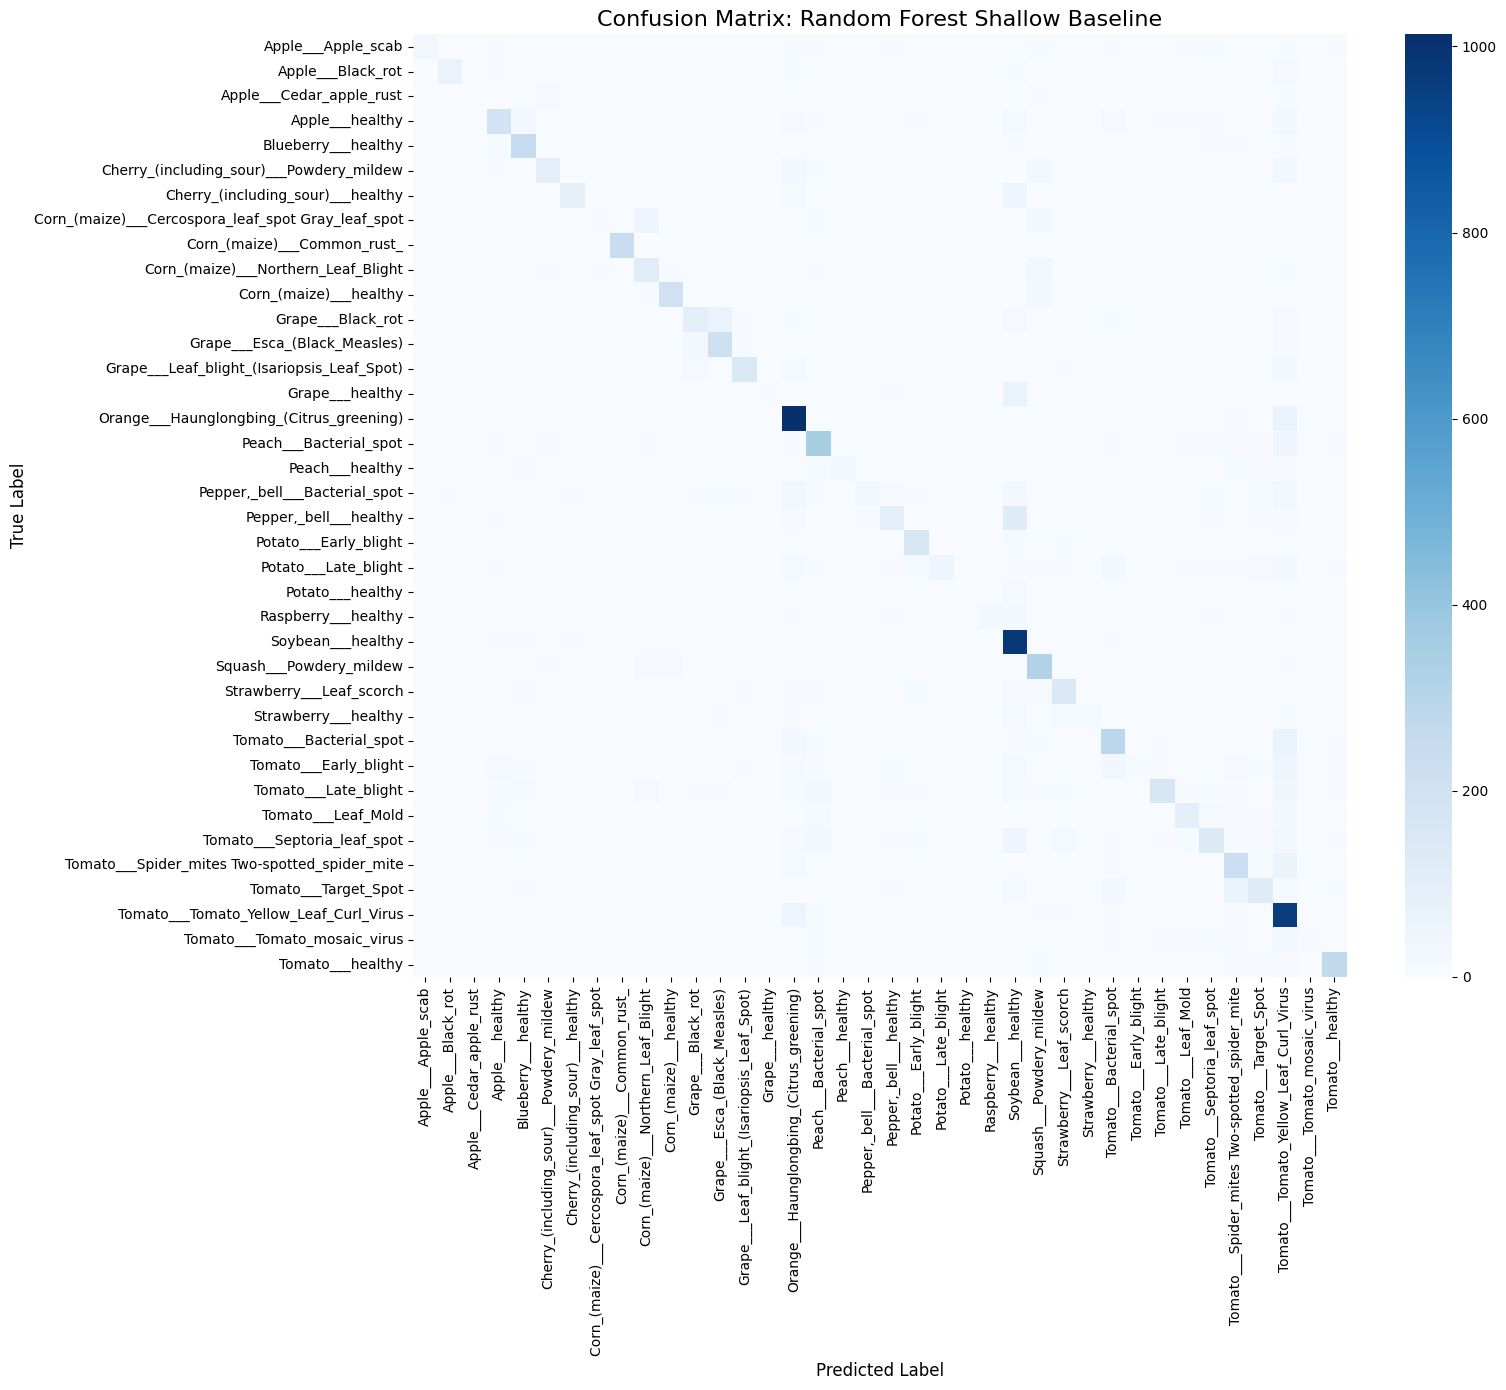


Detailed Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.7907    0.2698    0.4024       126
                                 Apple___Black_rot     0.7831    0.5242    0.6280       124
                          Apple___Cedar_apple_rust     1.0000    0.0182    0.0357        55
                                   Apple___healthy     0.6497    0.5805    0.6132       329
                               Blueberry___healthy     0.7163    0.8500    0.7774       300
          Cherry_(including_sour)___Powdery_mildew     0.6667    0.4667    0.5490       210
                 Cherry_(including_sour)___healthy     0.8073    0.5146    0.6286       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.4545    0.0485    0.0877       103
                       Corn_(maize)___Common_rust_     0.9876    1.0000    0.9938       239
               Corn_(maize)___Northern_Leaf_Bl

In [2]:
def plot_results(y_true, y_pred, classes):
    # Create Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=False, cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix: Random Forest Shallow Baseline', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Fixed: Removed 'max_iter'
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

plot_results(y_test, y_pred, le.classes_)